In [0]:
from pyspark.sql.types import *
import pyspark.sql.functions as f
import os,time
from pyspark import SparkContext
from pyspark.sql import SparkSession
 
spark = SparkSession.builder.appName("my_project_2").getOrCreate()
sc = spark.sparkContext

# Read Sub Demographic data

In [0]:
demographic_df = spark.read.parquet("/dbfs/mnt/coursedata2024/fwm-stb-data/Project2_demographic.parquet")
demographic_df.printSchema()
display(demographic_df.limit(10))

root
 |-- household_id: string (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- num_adults: integer (nullable = true)
 |-- num_generations: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- race_code: string (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- home_owner_status: string (nullable = true)
 |-- length_residence: integer (nullable = true)
 |-- home_market_value: integer (nullable = true)
 |-- net_worth: integer (nullable = true)
 |-- education_highest: integer (nullable = true)
 |-- gender_individual: string (nullable = true)



household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,education_highest,gender_individual
00000015,2,2,1,S,B,S,O,5,5,6,4,M
00000028,3,2,2,S,W,S,O,3,8,5,2,M
00000056,2,2,1,S,W,S,O,4,10,5,1,M
00000061,2,2,2,M,W,S,O,15,8,8,1,M
00000098,3,2,2,M,W,S,O,4,13,7,1,F
00000111,2,2,1,S,W,S,O,15,4,8,2,M
00000122,3,2,2,M,W,S,O,8,7,7,2,F
00000130,2,2,2,S,W,S,O,8,8,6,2,M
00000145,1,1,1,B,W,S,O,3,6,5,1,M
00000160,2,2,1,A,W,S,O,15,6,6,1,M


# Read Static Viewing Data

In [0]:
static_viewing_df = spark.read.parquet("/dbfs/mnt/coursedata2024/fwm-stb-data/Project2_static_viewing_data.parquet")
static_viewing_df.printSchema()
display(static_viewing_df.limit(10))

root
 |-- device_id: string (nullable = true)
 |-- event_date: integer (nullable = true)
 |-- event_time: integer (nullable = true)
 |-- station_num: string (nullable = true)
 |-- prog_code: string (nullable = true)
 |-- household_id: long (nullable = true)



device_id,event_date,event_time,station_num,prog_code,household_id
000000d8b042,20151101,500,31709,EP015686040014,1463331
000000fb0fe7,20151101,230000,11006,EP001151270249,1447701
0000010e4717,20151101,13000,49788,EP003267331348,1447541
0000015ce10e,20151101,153432,50001,EP013605340004,2880783
000004351a40,20151101,65207,59636,SP003189620000,2882159
000004d26feb,20151101,210550,14988,MV002161540000,405836
000005ac0b7c,20151101,194211,63322,EP015662900055,397950
000013fb3e40,20151101,123000,16374,SH006818540000,399721
00001602e18b,20151101,64445,18090,SP003189620000,400046
000002c427cf,20151101,52403,59337,MV002415180000,1300668


# Static Data Analysis

## Feature Extraction

In [0]:
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
import pyspark.sql.functions as F

# Normalize the numerical columns
numeric_headers = ["household_size", "num_adults", "num_generations", "length_residence", "home_market_value", "net_worth"]
for header in numeric_headers:
    max_value = demographic_df.agg({header: "max"}).collect()[0][0]
    demographic_df = demographic_df.withColumn(header, F.col(header) / max_value)

# Apply StringIndexer to the categorical columns, including 'education_highest'
indexer = StringIndexer(
    inputCols=["marital_status", "race_code", "dwelling_type", "home_owner_status", "gender_individual", "education_highest"],
    outputCols=["marital_status_index", "race_code_index", "dwelling_type_index", "home_owner_status_index", "gender_individual_index", "education_highest_index"]
)

indexer_model = indexer.fit(demographic_df)
demographic_df_with_indexes = indexer_model.transform(demographic_df)

# Apply OneHotEncoder to the indexed categorical columns
encoder = OneHotEncoder(
    inputCols=["marital_status_index", "race_code_index", "dwelling_type_index", "home_owner_status_index", "gender_individual_index", "education_highest_index"],
    outputCols=["marital_status_vec", "race_code_vec", "dwelling_type_vec", "home_owner_status_vec", "gender_individual_vec", "education_highest_vec"]
)

encoder_model = encoder.fit(demographic_df_with_indexes)
demographic_df_with_vec = encoder_model.transform(demographic_df_with_indexes)

# Combine all the numerical and one-hot encoded categorical columns into a single feature vector
assembler = VectorAssembler(
    inputCols=["household_size", "num_adults", "num_generations", "length_residence", "home_market_value", "net_worth",
               "marital_status_vec", "race_code_vec", "dwelling_type_vec", "home_owner_status_vec", "gender_individual_vec", "education_highest_vec"],
    outputCol="features"
)

demographic_df_with_features = assembler.transform(demographic_df_with_vec)

# Select only the 'household_id' and 'features' columns
final_df = demographic_df_with_features.select("household_id", "features")

# Show the final DataFrame with household_id and features
final_df.show(truncate=False)


+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|household_id|features                                                                                                                                                            |
+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|00000015    |[0.2222222222222222,0.3333333333333333,0.3333333333333333,0.3333333333333333,0.2631578947368421,0.6666666666666666,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0] |
|00000028    |[0.3333333333333333,0.3333333333333333,0.6666666666666666,0.2,0.42105263157894735,0.5555555555555556,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0]               |
|00000056    |[0.2222222222222222,0.3333333333333333,0.3333333333333333,0.26666666666666666,0.526315

## Visual Analysis

Resulting DataFrame:


household_id,x,y
00000015,0.0014795131340872216,3.59490432234753E-5
00000028,0.0019776484132439315,0.002306526338649176
00000056,0.0019905319370901718,-0.0022614040144358673
00000061,0.00249504309380227,-0.0016585894703275037
00000098,0.002127339819669514,-0.0017004459390460313
00000111,0.002150884080992407,0.002403966597227595
00000122,0.0020774347264273644,0.002890889023836614
00000130,0.002078459388223602,0.002345683951590691
00000145,0.0018226734114378499,-0.0020919965668254846
00000160,0.0021542109348225078,-0.0021135688470393468


<Figure size 1000x800 with 0 Axes>

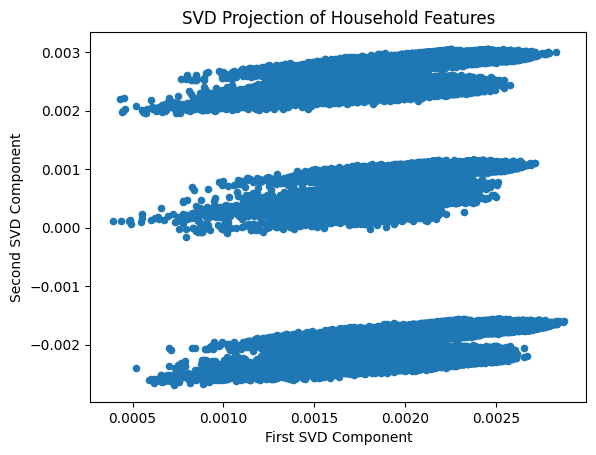

In [0]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.sql.functions import monotonically_increasing_id
import matplotlib.pyplot as plt


# Add an index to the original DataFrame
final_df_with_index = final_df.withColumn("index", monotonically_increasing_id())

# Convert DataFrame to RDD of Vectors
vector_rdd = final_df_with_index.select("features").rdd.map(lambda row: Vectors.dense(row.features))

# Create a RowMatrix from the RDD
mat = RowMatrix(vector_rdd)

# Compute the SVD using MLlib, with k=2
svd = mat.computeSVD(k=2, computeU=True)

# Get the U matrix (left singular vectors)
u = svd.U

# Convert U to a DataFrame with index
u_df = u.rows.zipWithIndex().map(lambda row: (row[1], float(row[0][0]), float(row[0][1]))).toDF(["index", "x", "y"])

# Join the original DataFrame with the SVD results
svd_df = final_df_with_index.join(u_df, "index").drop("index", "features")

# Show 10 rows from the resulting dataframe
print("Resulting DataFrame:")
display(svd_df.select("household_id", "x", "y").limit(10))

# Plot using the method suggested, with smaller dots
plt.figure(figsize=(10, 8))
svd_df.toPandas().plot.scatter(x='x', y='y')
plt.title('SVD Projection of Household Features')
plt.xlabel('First SVD Component')
plt.ylabel('Second SVD Component')
plt.show()

## Clustering

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.sql.window import Window
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import VectorUDT, DenseVector
import pyspark.sql.functions as F

# Assuming 'final_df' is still our DataFrame with 'household_id' and 'features' columns

# Step 1: Apply K-means clustering
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=8, seed=7)
model = kmeans.fit(final_df)
clustered_df = model.transform(final_df)

# Step 2: Define a UDF to calculate Euclidean distance
@udf(returnType=VectorUDT())
def subtract_vectors(v1, v2):
    return DenseVector([a - b for a, b in zip(v1, v2)])

euclidean_distance = udf(lambda v: float(v.norm(2)), returnType=DoubleType())

# Step 3: Get cluster centers
cluster_centers = model.clusterCenters()

# Step 4: Add the centroid column by mapping cluster to corresponding centroid
clustered_df = clustered_df.withColumn(
    "centroid", 
    F.udf(lambda x: DenseVector(cluster_centers[x]), VectorUDT())(col("cluster"))
)

# Step 5: Calculate the distance from the centroid
clustered_df = clustered_df.withColumn(
    "distance_from_centroid",
    euclidean_distance(subtract_vectors(col("features"), col("centroid")))
)

# Step 6: Select relevant columns
result_df = clustered_df.select("household_id", "cluster", "distance_from_centroid")

# Show 10 rows
result_df.show(10, truncate=False)


+------------+-------+----------------------+
|household_id|cluster|distance_from_centroid|
+------------+-------+----------------------+
|00000015    |7      |1.582545006068127     |
|00000028    |3      |0.8820895207245868    |
|00000056    |7      |0.5695799096085146    |
|00000061    |4      |0.631289135880363     |
|00000098    |4      |0.7913505715972418    |
|00000111    |3      |0.941462484265176     |
|00000122    |1      |0.5637962080630056    |
|00000130    |3      |0.7826149675017526    |
|00000145    |7      |1.152835366226235     |
|00000160    |2      |0.815249626053806     |
+------------+-------+----------------------+
only showing top 10 rows



## Visual Clustering

+------------+-------+---------------------+--------------------+
|household_id|cluster|x                    |y                   |
+------------+-------+---------------------+--------------------+
|00000015    |7      |-0.028094320765806948|0.2551547954941993  |
|00000028    |3      |0.6310123422068638   |0.2014434196175967  |
|00000056    |7      |-0.7545601844998397  |0.23203365783877333 |
|00000061    |4      |-0.7718987222358517  |-1.2250467142221824 |
|00000098    |4      |-0.7410156638473434  |-1.0796069322546156 |
|00000111    |3      |0.6420052146405326   |0.11661462500499419 |
|00000122    |1      |0.6515870441215106   |-1.1211070715670466 |
|00000130    |3      |0.6335825457272043   |0.16335536751482943 |
|00000145    |7      |-0.7599372294379908  |-0.28533577024239265|
|00000160    |2      |-0.7762629052681871  |-0.23706388807945883|
+------------+-------+---------------------+--------------------+
only showing top 10 rows



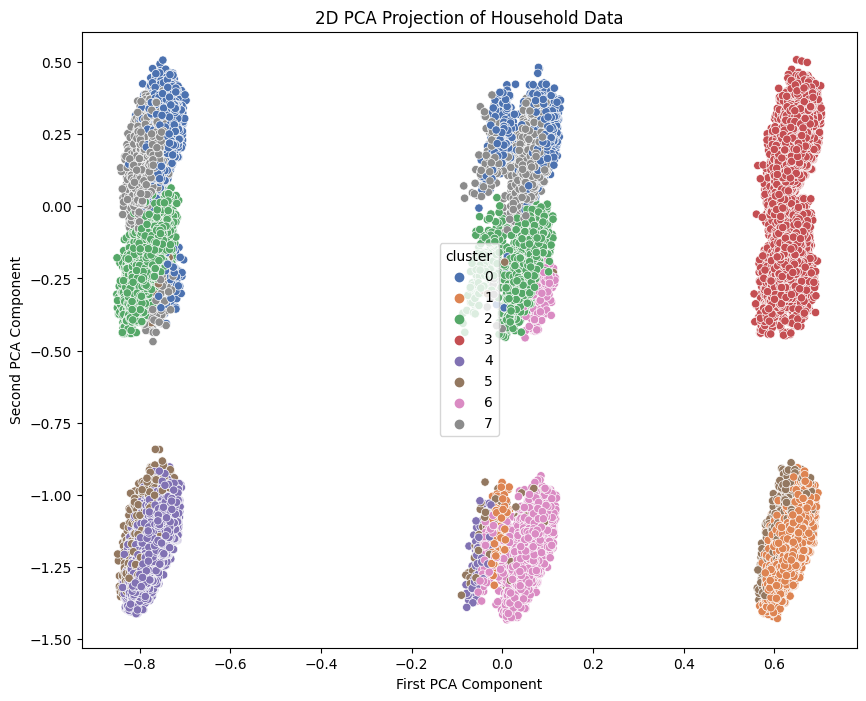

In [0]:
from pyspark.ml.feature import PCA
from pyspark.sql.functions import col, expr
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.linalg import Vectors, DenseVector

# Assuming 'clustered_df' is the DataFrame from the previous step with 'features' and 'cluster' columns

# Step 1: Apply PCA
pca = PCA(inputCol="features", outputCol="pca_features", k=2)
pca_model = pca.fit(clustered_df)
pca_df = pca_model.transform(clustered_df)

# Step 2: Convert 'pca_features' vector to array for easier access
# Define a UDF to convert VectorUDT to array
vector_to_array_udf = F.udf(lambda vector: vector.toArray().tolist(), ArrayType(DoubleType()))

# Convert pca_features to an array
pca_df = pca_df.withColumn("pca_array", vector_to_array_udf(col("pca_features")))

# Step 3: Extract the two components from the array
pca_df = pca_df.select("household_id", "cluster",
                       col("pca_array")[0].alias("x"),
                       col("pca_array")[1].alias("y"))

# Show 10 rows
pca_df.show(10, truncate=False)

# Step 4: Convert to Pandas DataFrame for plotting
pandas_df = pca_df.toPandas()

# Step 5: Plot the scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pandas_df, x="x", y="y", hue="cluster", palette="deep")
plt.title('2D PCA Projection of Household Data')
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Component')
plt.show()


## Dividing households into subsets

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col, when, lit

# Assuming 'clustered_df' is the DataFrame with 'household_id', 'cluster', and 'distance_from_centroid' columns

# Create a window specification
window_spec = Window.partitionBy("cluster").orderBy("distance_from_centroid")

# Add row number within each cluster
df_with_row_num = clustered_df.withColumn("row_num", row_number().over(window_spec))

# Create columns for 7ths and 11ths subsets
df_with_subsets = df_with_row_num.withColumn(
    "subset_7th", when(col("row_num") % 7 == 0, 1).otherwise(0)
).withColumn(
    "subset_11th", when(col("row_num") % 11 == 0, 1).otherwise(0)
).withColumn(
    "subset_full", lit(1)
)

# Show 10 rows of the resulting DataFrame
df_with_subsets.select("household_id", "cluster", "distance_from_centroid", "row_num", "subset_7th", "subset_11th", "subset_full").show(10, truncate=False)

# Create 24 DataFrames (3 subsets for each of the 8 clusters)
subsets = []
for i in range(8):
    # Full subset for cluster i
    full_subset = df_with_subsets.filter(col("cluster") == i).filter(col("subset_full") == 1)
    # 7th subset for cluster i
    subset_7th = df_with_subsets.filter(col("cluster") == i).filter(col("subset_7th") == 1)
    # 11th subset for cluster i
    subset_11th = df_with_subsets.filter(col("cluster") == i).filter(col("subset_11th") == 1)
    
    subsets.append((f"Cluster_{i}_Full", full_subset))
    subsets.append((f"Cluster_{i}_7th", subset_7th))
    subsets.append((f"Cluster_{i}_11th", subset_11th))

# Print the number of households in each subset
for name, subset in subsets:
    print(f"{name} subset count:", subset.count())



+------------+-------+----------------------+-------+----------+-----------+-----------+
|household_id|cluster|distance_from_centroid|row_num|subset_7th|subset_11th|subset_full|
+------------+-------+----------------------+-------+----------+-----------+-----------+
|02823130    |1      |0.5043294901115289    |1      |0         |0          |1          |
|02838392    |1      |0.5043294901115289    |2      |0         |0          |1          |
|01467865    |1      |0.5051029550936755    |3      |0         |0          |1          |
|02201874    |1      |0.5051029550936755    |4      |0         |0          |1          |
|01480958    |1      |0.5069681793039568    |5      |0         |0          |1          |
|02037847    |1      |0.5080791201047574    |6      |0         |0          |1          |
|02143764    |1      |0.5080791201047574    |7      |1         |0          |1          |
|02727722    |1      |0.5080791201047574    |8      |0         |0          |1          |
|00092568    |1      

## Cluster’s Viewing Analysis

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming we have 'df_with_subsets' from the previous code and 'viewing_df' with viewing data

def calculate_viewing_percentages(df, group_cols):
    return df.groupBy(*group_cols, "station_num") \
        .agg(F.count("*").alias("views")) \
        .withColumn("total_views", F.sum("views").over(Window.partitionBy(*group_cols))) \
        .withColumn("viewing_percentage", (F.col("views") / F.col("total_views")) * 100)


# Calculate viewing percentages for the entire population
total_viewing_percentages = calculate_viewing_percentages(static_viewing_df, []) \
    .select("station_num", F.col("viewing_percentage").alias("viewing_percentage_total"))


def calculate_diff_rank(subset_df, total_df):
    return subset_df.join(total_df, "station_num", "left") \
        .withColumn("diff_rank", F.col("viewing_percentage") - F.col("viewing_percentage_total")) \
        .select("station_num", "diff_rank")


def get_top_10_stations(diff_rank_df):
    return diff_rank_df.orderBy(F.col("diff_rank").desc()).limit(10)


def process_subset(static_viewing_df, subset_df, subset_name):
    # Join viewing data with subset data

    joined_df = static_viewing_df.join(subset_df, "household_id")
    
    # Calculate viewing percentages for the subset
    subset_percentages = calculate_viewing_percentages(joined_df, [])
    
    # Calculate diff rank for the subset
    diff_rank_df = calculate_diff_rank(subset_percentages, total_viewing_percentages)
    
    # Get top 10 stations for the subset
    top_10_df = get_top_10_stations(diff_rank_df)
    
    return top_10_df.withColumn("subset", F.lit(subset_name))

# Process each subset
results = []
for name, subset in subsets:
    result_df = process_subset(static_viewing_df, subset, name)
    results.append(result_df)

# Combine results
final_results = results[0]
for df in results[1:]:
    final_results = final_results.union(df)

# Display results

for i in range(8):  # For each cluster
    print(f"\n=== Cluster {i} ===")
    for subset_type in ["Full", "7th", "11th"]:
        print(f"\n--- {subset_type} Subset ---")
        final_results.filter(F.col("subset") == f"Cluster_{i}_{subset_type}") \
            .select("station_num", "diff_rank") \
            .show(10, truncate=False)



=== Cluster 0 ===

--- Full Subset ---
+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|11221      |0.2694184506937065 |
|11069      |0.1637304291277048 |
|12574      |0.1602521884547885 |
|11207      |0.15991514116551064|
|11158      |0.1547775482926388 |
|16615      |0.15455813582655742|
|10918      |0.14882050217430942|
|10171      |0.12143200600466675|
|14909      |0.11904920152342569|
|10145      |0.11516500337204261|
+-----------+-------------------+


--- 7th Subset ---
+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|11221      |0.29016686537191383|
|14902      |0.2486241019828236 |
|10171      |0.20104391453914228|
|11069      |0.16545753528931334|
|11158      |0.1617725432371261 |
|10145      |0.16044729799375101|
|16615      |0.15325232882687978|
|10510      |0.14057249092153584|
|74796      |0.1398037676324687 |
|10918      |0.13577139560563534|
+-----------+--------

# Dynamic Data Analysis - Streaming

In [0]:
SCHEMA = "device_id STRING, event_date INT, event_time INT, station_num STRING, prog_code STRING, household_id STRING"
kafka_server = "kafka.eastus.cloudapp.azure.com:29092"
topic = "view_data" 
OFFSETS_PER_TRIGGER = 50000

streaming_df = spark.readStream\
                  .format("kafka")\
                  .option("kafka.bootstrap.servers", kafka_server)\
                  .option("subscribe", topic)\
                  .option("startingOffsets", "earliest")\
                  .option("failOnDataLoss",False)\
                  .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER)\
                  .load()\
                  .select(f.from_csv(f.decode("value", "US-ASCII"), schema=SCHEMA).alias("value")).select("value.*")

viewing_counts = streaming_df.groupBy("event_date").count()
count_viewing_query =viewing_counts.writeStream\
.queryName('num_viewing')\
.format("memory")\
.outputMode("complete")\
.start()

time.sleep(10)

for i in range(10):
    print("Batch number: "+str(i))
    print(count_viewing_query.status)
    spark.sql('SELECT * FROM num_viewing').show()
    time.sleep(20)
    
count_viewing_query.stop()

Batch number: 0
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
|  20150913|12582|
|  20151004|18896|
|  20151018|18522|
+----------+-----+

Batch number: 1
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+------+
|event_date| count|
+----------+------+
|  20150913| 98115|
|  20151004|104351|
|  20151018| 97534|
+----------+------+

Batch number: 2
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+------+
|event_date| count|
+----------+------+
|  20150913|167737|
|  20151004|172268|
|  20151018|159995|
+----------+------+

Batch number: 3
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+------+
|event_date| count|
+----------+------+
|  20150913|251690|
|  20151004|261732|
|  20151018|236578|
+----------+------+

Batch number: 4
{'message': 'Processing

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.window import Window
import time

# Assuming we have 'df_with_subsets' from the previous code
# We'll extract only the 7th subsets
subsets_7th = [(f"Cluster_{i}_7th", df_with_subsets.filter(F.col("cluster") == i).select("household_id")) for i in range(8)]

# Iterate through each cluster in subsets_7th and convert household_id to long
long_subsets_7th = []
for cluster_name, df in subsets_7th:
    # Convert household_id to long
    df_long = df.withColumn('household_id', col('household_id').cast('long'))
    
    # Append the updated DataFrame to the new list
    long_subsets_7th.append((cluster_name, df_long))

# Convert household_id to long in streaming_df
streaming_df = streaming_df.withColumn('household_id', col('household_id').cast('long'))

# Function to calculate viewing percentages
def calculate_viewing_percentages(df, group_cols):
    return df.groupBy(*group_cols, "station_num") \
        .agg(F.count("*").alias("views")) \
        .withColumn("total_views", F.sum("views").over(Window.partitionBy(*group_cols))) \
        .withColumn("viewing_percentage", (F.col("views") / F.col("total_views")) * 100)

# Function to calculate diff rank
def calculate_diff_rank(subset_df, total_df):
    return subset_df.join(total_df, "station_num", "left") \
        .withColumn("diff_rank", F.col("viewing_percentage") - F.col("viewing_percentage_total")) \
        .select("station_num", "diff_rank")

# Function to get top 10 stations
def get_top_10_stations(diff_rank_df):
    return diff_rank_df.orderBy(F.col("diff_rank").desc()).limit(10)

# Function to process subset
def process_subset(viewing_df, subset_df, subset_name):
    # Join viewing data with subset data
    joined_df = viewing_df.join(subset_df, "household_id")
    
    # Calculate viewing percentages for the entire population
    total_viewing_percentages = calculate_viewing_percentages(viewing_df, []) \
        .select("station_num", F.col("viewing_percentage").alias("viewing_percentage_total"))
    
    # Calculate viewing percentages for the subset
    subset_percentages = calculate_viewing_percentages(joined_df, [])
    
    # Calculate diff rank for the subset
    diff_rank_df = calculate_diff_rank(subset_percentages, total_viewing_percentages)
    
    # Get top 10 stations for the subset
    top_10_df = get_top_10_stations(diff_rank_df)
    
    return top_10_df.withColumn("subset", F.lit(subset_name))

# Function to process each batch
def process_batch(df, epoch_id, subsets_7th):
    print(f"\n=== Batch {epoch_id} ===")
    
    # Process each subset
    results = []
    for name, subset in subsets_7th:
        result_df = process_subset(df, subset, name)
        results.append(result_df)
    
    # Combine results
    final_results = results[0]
    for df in results[1:]:
        final_results = final_results.union(df)
    
    # Display results
    for i in range(8):  # For each cluster
        print(f"\n--- Cluster {i} (7th Subset) ---")
        final_results.filter(F.col("subset") == f"Cluster_{i}_7th") \
            .select("station_num", "diff_rank") \
            .show(10, truncate=False)

# Start the streaming query
query = streaming_df.writeStream \
    .foreachBatch(lambda df, epoch_id: process_batch(df, epoch_id, long_subsets_7th)) \
    .start()

# Wait for 3 batches to complete
for _ in range(3):
    time.sleep(20)  # Wait for 60 seconds between checks

# Stop the query
query.stop()



=== Batch 0 ===

--- Cluster 0 (7th Subset) ---
+-----------+------------------+
|station_num|diff_rank         |
+-----------+------------------+
|16361      |1.9654723049434188|
|17727      |1.502337105419893 |
|61522      |1.4894723049434189|
|11490      |1.4481000595592615|
|20430      |1.424557474687314 |
|10986      |1.2754389517569984|
|48639      |1.2434389517569984|
|65025      |1.1805741512805241|
|10057      |1.113201905896367 |
|19587      |0.9898630136986301|
+-----------+------------------+


--- Cluster 1 (7th Subset) ---
+-----------+------------------+
|station_num|diff_rank         |
+-----------+------------------+
|19580      |1.0967027027027025|
|14902      |1.0605564909171468|
|55887      |0.9858159799143404|
|11949      |0.8916366858661942|
|10171      |0.8405564909171468|
|11581      |0.699353714370108 |
|10330      |0.6718018018018019|
|14767      |0.6479763698124354|
|11593      |0.5893489883325949|
|10093      |0.5630471126864571|
+-----------+--------------